# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#Importing DL libraries
import keras
# import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Displaying Images

In [2]:
picture_size = 48 # 48x48
folder_path = '/kaggle/input/face-expression-recognition-dataset/images'

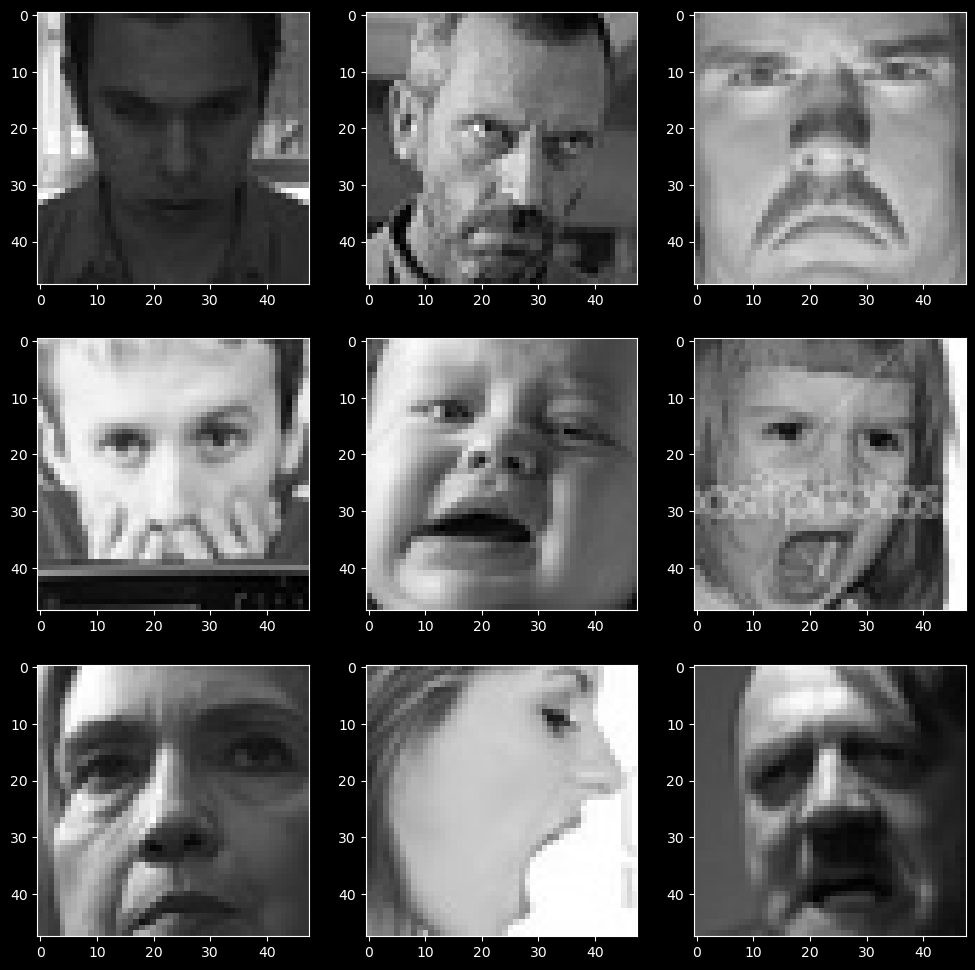

In [3]:
# Showing the images
expression = 'angry'
plt.style.use('dark_background')
plt.figure(figsize = (12,12)) # creates an empty plot of given figsize
for i in range(1,10,1):
    plt.subplot(3,3,i)
    img = load_img(folder_path + "/" + "train/" + expression + "/" +
                  os.listdir(folder_path + "/" + "train/" + expression + "/")[i], target_size = (picture_size, picture_size))
    plt.imshow(img)
plt.show()    

# Making Training & Validation Data

In [4]:
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path + "/" + "train/", target_size = (picture_size, picture_size),
                                             color_mode = "grayscale", batch_size = batch_size, class_mode = 'categorical',
                                             shuffle = True)
test_set = datagen_val.flow_from_directory(folder_path + "/" + 'validation/', target_size = (picture_size, picture_size),
                                          color_mode = "grayscale", batch_size = batch_size, class_mode = 'categorical',
                                          shuffle = False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [5]:
num_of_classes = 7
model = Sequential()

# 1st CNN layer
model.add(Conv2D(64,(3,3), padding = 'same', input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128,(5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512,(3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_of_classes, activation = 'softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Fitting the model with Training & Validation Data

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/kaggle/working/model.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_lr]
epochs = 48

In [7]:
history = model.fit_generator(generator = train_set, steps_per_epoch = train_set.n//train_set.batch_size, 
                             epochs = epochs, validation_data = test_set, validation_steps = test_set.n//test_set.batch_size, 
                             callbacks = callbacks_list
                             )

/tmp/ipykernel_28/3247217774.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator = train_set, steps_per_epoch = train_set.n//train_set.batch_size,


Epoch 1/48


2023-07-21 14:34:32.933849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 257s 1s/step - loss: 2.0084 - accuracy: 0.2348 - val_loss: 1.7502 - val_accuracy: 0.2979 - lr: 1.0000e-04
Epoch 2/48
225/225 [==============================] - 57s 253ms/step - loss: 1.8364 - accuracy: 0.2893 - val_loss: 1.7276 - val_accuracy: 0.3141 - lr: 1.0000e-04
Epoch 3/48
225/225 [==============================] - 57s 251ms/step - loss: 1.7241 - accuracy: 0.3401 - val_loss: 1.6539 - val_accuracy: 0.3614 - lr: 1.0000e-04
Epoch 4/48
225/225 [==============================] - 57s 251ms/step - loss: 1.6509 - accuracy: 0.3651 - val_loss: 1.5485 - val_accuracy: 0.4047 - lr: 1.0000e-04
Epoch 5/48
225/225 [==============================] - 56s 249ms/step - loss: 1.5919 - accuracy: 0.3924 - val_loss: 1.5193 - val_accuracy: 0.4151 - lr: 1.0000e-04
Epoch 6/48
225/225 [==============================] - 57s 254ms/step - loss: 1.5354 - accuracy: 0.4083 - val_loss: 1.4597 - val_accuracy: 0.4381 - lr: 1.0000e-04
Epoch 7/48
225/225 [=====================

# Plotting Accuracy & Losses

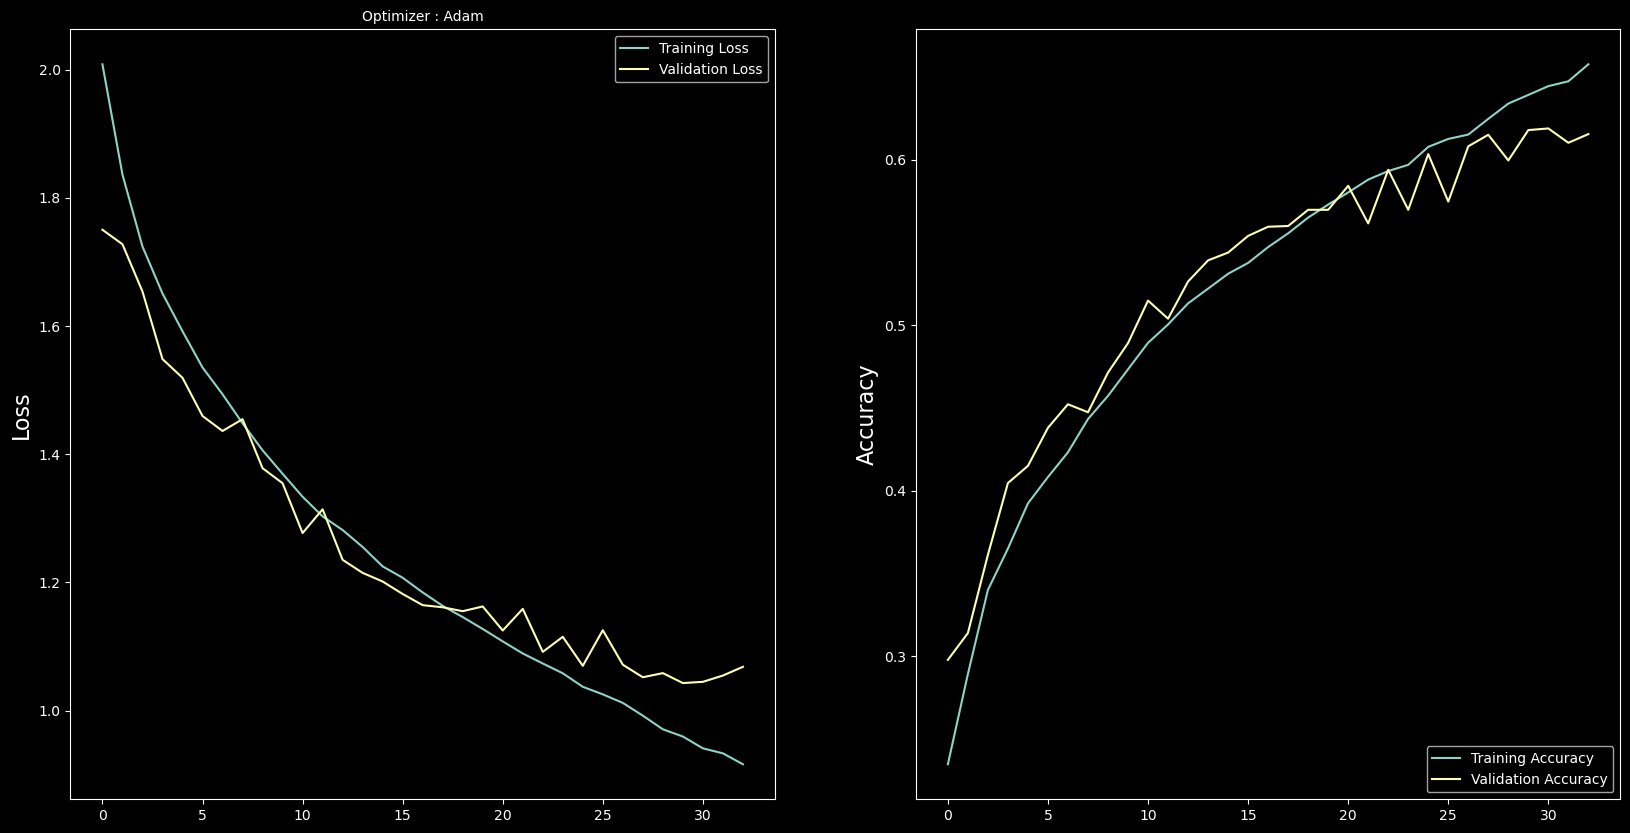

In [11]:
plt.style.use('dark_background')

plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Optimizer : Adam', fontsize = 10)
plt.ylabel('Loss', fontsize = 16)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize = 16)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [12]:
import os
from tensorflow.keras.models import load_model


In [15]:
model.save(os.path.join('/kaggle/working/models.h5', 'facialexpression.h5'))